In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import xobjects as xo
import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('../PIMMStutorials_CNAOlattice/cnao_lattice_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/429 [00:00<?, ?it/s]

Done loading line from dict.           


### Define reference particle

In [4]:
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=60e6)

### Match

In [5]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-3, dqy=-1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.666, qy=1.74, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 3.415         
Matching: model call n. 22               
Optimize - end penalty:  3.10671e-06


### Twiss

In [6]:
tw = line.twiss(method='4d')

### Build a matched beam distribution

In [7]:
# Define number of turns and number of particles for the simulation
num_turns = 4000
num_particles = 20
beam_intensity = 1e10 # p+

# Generate Gaussian distribution in normalized phase space
x_norm = 0
px_norm = 0
y_norm = 0
py_norm = 0

# Generate Gaussian momentum distribution (mean 0.0, std spread 1e-4)
delta = 0

# Particles arrival time spread over one turn
zeta = np.linspace(-0.5, 0.5, num_particles) * line.get_length()

# Assemble Particles object
particles = line.build_particles(
    x_norm=x_norm, px_norm=px_norm, 
    y_norm=y_norm, py_norm=py_norm,
    delta=delta,
    zeta=zeta,
    method='4d',
    weight=beam_intensity / num_particles,
    nemitt_x=0.52e-6, nemitt_y=1e-8,
)

# save initial state
p0 = particles.copy()

In [9]:
# Turn off the resonance sextupole
line['sr'] = 0

In [10]:
# Get details for existing RF cavity element in CNAO lattice
tab = line.get_table()
myRow=tab.rows['s8_020a_cav']
myRow.cols['s','name','element_type','s_start','s_center','s_end']

Table: 1 row, 6 cols
name                    s element_type       s_start      s_center         s_end
s8_020a_cav       48.4291 Drift              48.4291       49.2291       50.0291

In [11]:
t_s = np.array([0., 5e-3])
E_kin = np.array([60, 65])

line.energy_program = xt.EnergyProgram(t_s=t_s, kinetic_energy0=E_kin*1e6)

t_plot = np.linspace(0, 5e-3, 20)
E_kin_plot = line.energy_program.get_kinetic_energy0_at_t_s(t_plot)
f_rev_plot = line.energy_program.get_frev_at_t_s(t_plot)

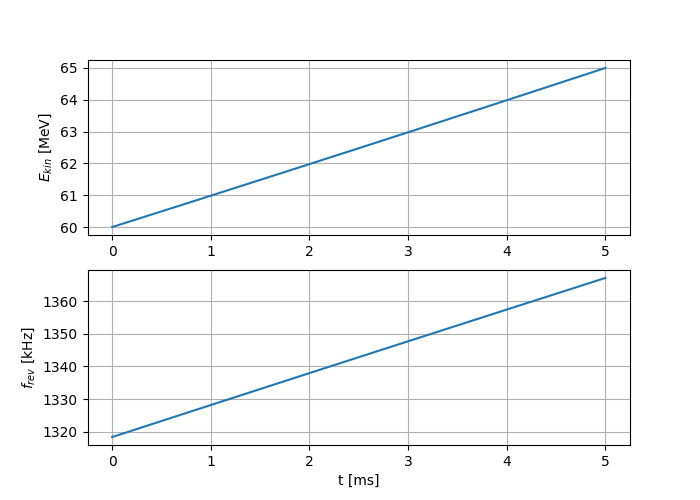

In [12]:
# Plot energy and revolution frequency vs time
plt.close('all')
plt.figure(figsize=(7, 5))

ax1 = plt.subplot(2,1,1)
plt.plot(t_plot * 1e3, E_kin_plot * 1e-6)
plt.ylabel(r'$E_{kin}$ [MeV]')
plt.grid()

ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(t_plot * 1e3, f_rev_plot * 1e-3)
plt.ylabel(r'$f_{rev}$ [kHz]')
plt.xlabel('t [ms]')
plt.grid()

### Set realistic septum aperture

In [16]:
line['septum_aperture'].max_x = 0.035

### Switch to multithreaded context to gain speed

In [17]:
ctx = xo.ContextCpu(omp_num_threads='auto')

### Define quantities to be logged during tracking

In [18]:
# User-defined quantity to be logged (functions executed at every turn, output is automatically logged).
def measure_intensity(line, particles):
    mask_alive = particles.state > 0
    intensity = np.sum(particles.weight[mask_alive])
    return intensity

log = xt.Log('sr',                          # vars to be logged
             intensity=measure_intensity)   # user-defined function to be logged

### Enable time-dependent vars update for tracking

In [19]:
line.enable_time_dependent_vars = True

### Introduce RF Cavity

In [20]:
# Revolution frequency of the reference particle
f_rev = 1 / tw.T_rev0
print(f_rev)

1318348.9587366662


In [21]:
# Introduce RF cavity with lag (acceleration)
rf_cavity = xt.Cavity(voltage=2e3, frequency=f_rev, lag=40)

In [22]:
# Install the custom RF cavity (thin element) in the center of the actual RF cavity.
# This way the actual RF cavity of the CNAO lattice (which is considered a drift) is sliced.
line.discard_tracker()
line.insert('rf_cavity', rf_cavity, at=49.2291)
line.build_tracker(_context=ctx)

Slicing line:   0%|          | 0/429 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [23]:
# Assign calculated frequency increase for acceleration according to the energy program
line.functions['fun_f_rf'] = xt.FunctionPieceWiseLinear(x=t_plot, y=f_rev_plot)
line['rf_cavity'].frequency = line.functions['fun_f_rf'](line.ref['t_turn_s'])

### Reset the model

In [24]:
# Reset simulation time
line.vars['t_turn_s'] = 0

### Log excitation parameters

In [25]:
log = xt.Log('t_turn_s',
    intensity=measure_intensity)       # user-defined functions to be logged

### Track!

In [26]:
line.track(p0, num_turns=num_turns, with_progress=True, turn_by_turn_monitor=True,
           log=log)

Tracking:   0%|          | 0/4000 [00:00<?, ?it/s]

In [27]:
# Record particle coordinates turn by turn
rec = line.record_last_track
# Get turn by turn normalized coordinates 
nc = tw.get_normalized_coordinates(rec)

### Plot logged quantities

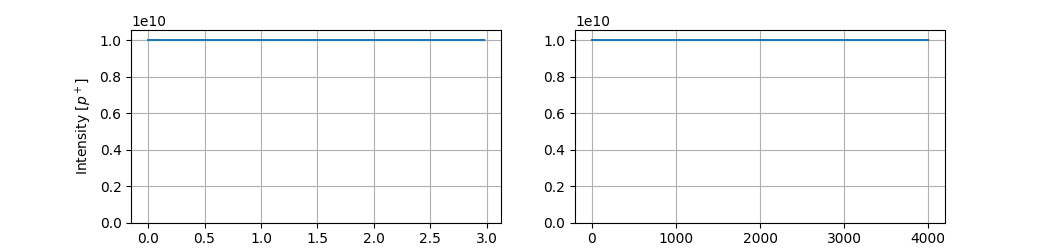

In [28]:
plt.figure(figsize=(10.5, 2.5))

t_ms = np.array(line.log_last_track['t_turn_s']) * 1e3

ax1 = plt.subplot(1,2,1)
plt.plot(t_ms, line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Intensity [$p^+$]')
plt.grid()

ax2 = plt.subplot(1,2,2)
plt.plot(line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.grid()

### Plot particles after tracking

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


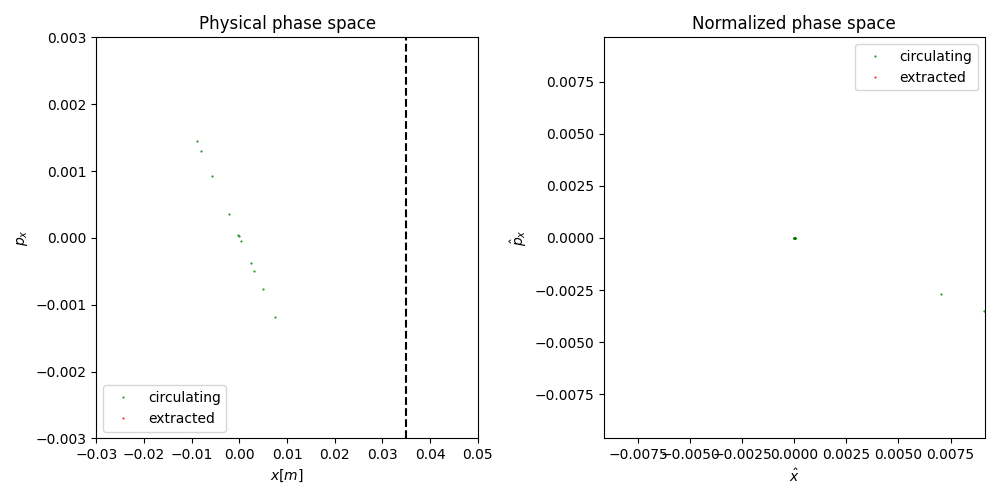

In [29]:
mask_alive = p0.state>0
mask_lost = ~mask_alive

# Get particles normalized coordinates
p_nc = tw.get_normalized_coordinates(p0)

plt.figure(figsize=(10, 5))
ax_g = plt.subplot(1, 2, 1, title='Physical phase space')
ax_n = plt.subplot(1, 2, 2, title='Normalized phase space')

ax_g.plot(p0.x[mask_alive], p0.px[mask_alive],
         '.', markersize=1, color='green', label='circulating')
ax_g.plot(p0.x[mask_lost], p0.px[mask_lost],
         '.', markersize=1, color='red', label='extracted')
ax_g.set_xlim(-0.03, 0.05); ax_g.set_ylim(-3e-3, 3e-3)
ax_g.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
ax_g.set_xlabel(r'${x} [m]$')
ax_g.set_ylabel(r'${p}_x$')
ax_g.legend()

ax_n.plot(p_nc.x_norm[mask_alive], p_nc.px_norm[mask_alive],
         '.', markersize=1, color='green', label='circulating')
ax_n.plot(p_nc.x_norm[mask_lost], p_nc.px_norm[mask_lost],
         '.', markersize=1, color='red', label='extracted')
ax_n.set_xlim(-0.015, 0.015); ax_n.set_ylim(-0.01, 0.01)
ax_n.set_aspect('equal', adjustable='datalim')
ax_n.set_xlabel(r'$\hat{x}$')
ax_n.set_ylabel(r'$\hat{p}_x$')
ax_n.legend()

plt.tight_layout()

plt.show()

Text(0.5, 0, 'z [m]')

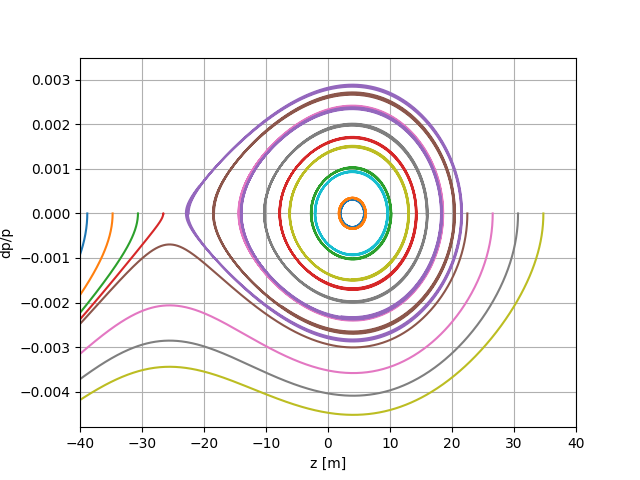

In [31]:
# Plot longitudinal phase space for acceleration for all the particles
plt.figure()
for part in range(0, 19):
    
    plt.plot((rec.zeta[part,:]), rec.delta[part,:])
plt.grid()
plt.xlim(-40, 40)
plt.ylim(-4.8e-3,3.5e-3)
plt.ylabel("dp/p")
plt.xlabel("z [m]")